# Feature overview

In [26]:
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

from data.make_dataset import clean_application_data, add_ratio_features
from features.make_features import load_feature_config
from util.util import transform_omit_model

## Loading data

In [13]:
df = pd.read_csv('../data/raw/application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
config = load_feature_config("../src/config.yaml")
target = config["target"]
num_features = config["numeric_features"]
cat_features = config["categorical_features"]

feature_list = num_features + cat_features

In [22]:
df = clean_application_data(df)
df = add_ratio_features(df)

X = df[feature_list]
y = df[target]

In [17]:
pipeline = joblib.load("../artifacts/logreg_pipeline.pkl")

In [23]:
features = pipeline[:-1].get_feature_names_out()

X = pd.DataFrame(transform_omit_model(pipeline, X), columns=features)

## Metrics for selected features

### AUC and Gini

In [27]:
def single_feature_auc(feature_values, target):
    auc = roc_auc_score(target, feature_values)
    return max(auc, 1 - auc)

feature_stats = []

for col in features:
    auc = single_feature_auc(X[col], y)
    gini = 2 * auc - 1

    feature_stats.append({
        "feature": col,
        "AUC": auc,
        "Gini": gini
    })

feature_stats_df = pd.DataFrame(feature_stats)


### Information Value (IV)

In [46]:
def calculate_iv(feature_raw, target, bins=10):
    df = pd.DataFrame({"feature": feature_raw, "target": target})
    df["bin"] = pd.qcut(df["feature"], q=bins, duplicates="drop")

    grouped = df.groupby("bin")["target"].agg(["count", "sum"])
    grouped.columns = ["total", "bad"]
    grouped["good"] = grouped["total"] - grouped["bad"]

    dist_good = grouped["good"] / grouped["good"].sum()
    dist_bad = grouped["bad"] / grouped["bad"].sum()

    woe = np.log((dist_good + 1e-6) / (dist_bad + 1e-6))
    iv = ((dist_good - dist_bad) * woe).sum()

    return iv

feature_stats_df["IV"] = [
    calculate_iv(X[col], y)
    for col in features
]

## Overall

In [47]:
feature_stats_df.sort_values("IV", ascending=False)

,feature,AUC,Gini,IV
2,AMT_GOODS_PRICE,0.533335,0.066670,0.002513
4,EMPLOYMENT_YEARS,0.579323,0.158647,0.002457
3,AGE_YEARS,0.583005,0.166010,0.001517
7,ANNUITY_TO_CREDIT_RATIO,0.532055,0.064110,0.001460
11,OCCUPATION_TYPE,0.519780,0.039560,0.001414
10,NAME_EDUCATION_TYPE,0.545355,0.090710,0.001130
0,AMT_CREDIT,0.518584,0.037169,0.000975
5,CREDIT_TO_INCOME_RATIO,0.501909,0.003817,0.000856
1,AMT_ANNUITY,0.500080,0.000159,0.000653
6,ANNUITY_TO_INCOME_RATIO,0.519528,0.039056,0.000628


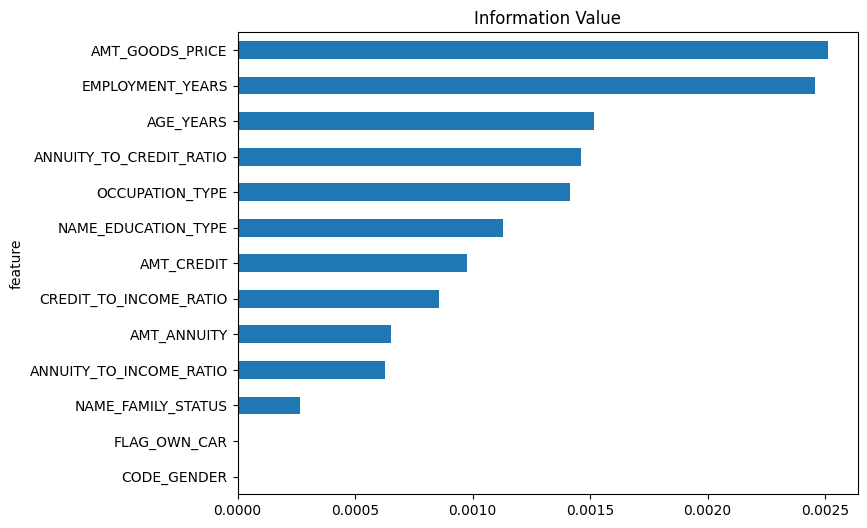

In [49]:
import matplotlib.pyplot as plt

feature_stats_df.sort_values("IV").plot(
    x="feature", y="IV", kind="barh", figsize=(8,6), legend=False
)
plt.title("Information Value")
plt.show()